# Set Card Game: Relational Neural Network Experiments

## Set Up

In [1]:
import itertools
import numpy as np
import sklearn.model_selection
import sklearn.metrics

import wandb

import tensorflow as tf

# %load_ext autoreload
# %autoreload 2
from relational_neural_networks import *
from utils import *

### Generate dataset for set card game

In [2]:
colors = (0, 1, 2)
shapes = (0, 1, 2)
fills = (0, 1, 2)
nums = (0, 1, 2)

color_dict = {0: 'red', 1: 'green', 2: 'blue'}
shape_dict = {0: 'bar', 1: 'squiggle', 2: 'diamond'}
fill_dict = {0: 'filled', 1: 'striped', 2: 'empty'}
num_dict = {0: '1', 1: '2', 2: '3'}

In [3]:
# space of possible 'entities' / cards: product space of color, shape, and fill attributes
entity_space = list(itertools.product(colors, shapes, fills, nums))
print('# of possible entities: ', len(entity_space))

# of possible entities:  81


In [4]:
# space of triplets: all possible combinations of triplets of the 27 cards
triplet_space = list(itertools.permutations(entity_space, 3))
# triplet_space = list(itertools.combinations(entity_space, 3))
# triplet_space = list(itertools.product(entity_space, repeat=3))
print('size of triplet space: ', len(triplet_space))

size of triplet space:  511920


In [5]:
# create a dictionary mapping each entity to a one_hot encoding of its attributes (e.g.: is_red, is_diamond, etc.)
entity_encodings = {}

for entity in entity_space:
    c, s, f, n = entity
    encoding = [0]*4*3
    encoding[c] = 1
    encoding[s + 3] = 1
    encoding[f + 6] = 1
    encoding[n + 9] = 1
    entity_encodings[entity] = tuple(encoding)

# define encoding function
def encode_entity(entity):
    return entity_encodings[entity]

def encode_triplet(triplet):
    return tuple(encode_entity(entity) for entity in triplet)

In [6]:
def classify_triplet(triplet):

    for attr in (0, 1, 2, 3): # check each attribute (color, shape, fill, num)
        attr_vals = [entity[attr] for entity in triplet]
        all_same = len(set(attr_vals)) == 1
        all_different = len(set(attr_vals)) == 3
        if not (all_same or all_different):
            return False

    return True

class_names = ['non-set', 'set']

In [7]:
X = triplet_space
y = np.array([classify_triplet(triplet) for triplet in triplet_space])

In [8]:
print('proportion of sets in triplet space: ', np.mean(y))

proportion of sets in triplet space:  0.012658227848101266


In [9]:
# samples of sets:
def get_entity_desc(entity):
    c, s, f, n = entity
    c = color_dict[c]
    s = shape_dict[s]
    f = fill_dict[f]
    n = num_dict[n]
    return (c, s, f, n)


print('samples of sets:')
sets = [x_ for x_, y_ in zip(X,y) if y_]
sets_sample = [sets[i] for i in np.random.choice(len(sets), size=5)]
for set_ in sets_sample:
    print(tuple(get_entity_desc(entity) for entity in set_))

# samples of non-sets:
print()
print('samples of non-sets:')
non_sets = [x_ for x_, y_ in zip(X,y) if not y_]
nonsets_sample = [non_sets[i] for i in np.random.choice(len(non_sets), size=5)]
for nonset_ in nonsets_sample:
    print(tuple(get_entity_desc(entity) for entity in nonset_))

samples of sets:
(('green', 'squiggle', 'filled', '2'), ('blue', 'squiggle', 'striped', '3'), ('red', 'squiggle', 'empty', '1'))
(('red', 'squiggle', 'filled', '3'), ('green', 'squiggle', 'filled', '3'), ('blue', 'squiggle', 'filled', '3'))
(('green', 'diamond', 'empty', '1'), ('red', 'bar', 'empty', '1'), ('blue', 'squiggle', 'empty', '1'))
(('green', 'diamond', 'filled', '1'), ('green', 'bar', 'empty', '2'), ('green', 'squiggle', 'striped', '3'))
(('red', 'bar', 'empty', '2'), ('red', 'bar', 'filled', '1'), ('red', 'bar', 'striped', '3'))

samples of non-sets:
(('blue', 'bar', 'filled', '2'), ('red', 'squiggle', 'striped', '2'), ('green', 'bar', 'striped', '2'))
(('red', 'diamond', 'filled', '3'), ('green', 'bar', 'filled', '3'), ('blue', 'bar', 'empty', '2'))
(('green', 'squiggle', 'striped', '2'), ('red', 'bar', 'striped', '3'), ('green', 'bar', 'empty', '2'))
(('blue', 'bar', 'striped', '3'), ('green', 'bar', 'filled', '2'), ('green', 'bar', 'empty', '3'))
(('green', 'bar', 'strip

In [10]:
X_enc = np.array([encode_triplet(triplet) for triplet in X])
X_enc.shape # (n_samples, n_entities, dim_encoding)

(511920, 3, 12)

In [11]:
# the data is highly imbalanced; create a balanced dataset by random undersampling
import imblearn.under_sampling
resampler = imblearn.under_sampling.RandomUnderSampler()
res_idx, y_res = resampler.fit_resample(np.array(range(len(y))).reshape(-1,1), y)
X_enc_res = np.array(X_enc) [np.squeeze(res_idx)]

# split training, validation, and testing sets
test_size = 0.4
val_size = 0.1

train_idx, test_idx = sklearn.model_selection.train_test_split(range(len(y_res)), test_size=test_size, stratify=y_res)
X_test = [X_enc_res[i] for i in test_idx]
y_test = [int(y_res[i]) for i in test_idx]

y_train = [int(y_res[i]) for i in train_idx]

train_idx, val_idx = sklearn.model_selection.train_test_split(train_idx, test_size=val_size/(1-test_size), stratify=y_train)

X_train = [X_enc_res[i] for i in train_idx]
y_train = [int(y_res[i]) for i in train_idx]
X_val = [X_enc_res[i] for i in val_idx]
y_val = [int(y_res[i]) for i in val_idx]

y_train = tf.one_hot(y_train, 2)
y_val = tf.one_hot(y_val, 2)
y_test = tf.one_hot(y_test, 2)

# create tensorflow datasets
batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

2022-10-26 20:12:34.147352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 20:12:34.155216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 20:12:34.155898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 20:12:34.157671: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
print(f'# of training samples:   {len(y_train): 5}')
print(f'# of validation samples: {len(y_val): 5}')
print(f'# of testing samples:    {len(y_test): 5}')

# of training samples:    6479
# of validation samples:  1297
# of testing samples:     5184


## Models

In [13]:
# set up W&B logging
%env "WANDB_NOTEBOOK_NAME" "set-experiments.ipynb"
import wandb
wandb.login(key='283ce55537fabf61a55a960f2788ffcbf12a5b46')

env: "WANDB_NOTEBOOK_NAME"="set-experiments.ipynb"


wandb: Currently logged in as: awni00. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [28]:
# define common components across models

def create_callbacks():
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'),
        wandb.keras.WandbCallback(
            monitor="val_loss", log_weights=True, log_gradients=True, save_model=True, save_graph=True,
            training_data=train_ds, validation_data=val_ds,
            labels=['non-set', 'set'], predictions=64, compute_flops=True)
        ]
    return callbacks

metrics = [
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Precision(class_id=1, name='precision'),
        tf.keras.metrics.Recall(class_id=1, name='recall'),
        tf.keras.metrics.AUC(curve='ROC', multi_label=True, name='auc')
        ]

loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.SGD(learning_rate=0.01)

fit_kwargs = {'epochs': 100, 'batch_size': 128, 'shuffle': True}

def eval_metrics(model):
    
    print('test set')
    pred_proba_test = model.predict(test_ds)
    pred_test = np.argmax(pred_proba_test, axis=1)
    print(sklearn.metrics.classification_report(y_test[:,1], pred_test))
    
    return pred_proba_test, pred_test

def log_to_wandb(y_test, pred_proba_test, pred_test):
    # log test-set metrics to W&B
    y_test = np.array(y_test[:,1])
    wandb.log({"pr": wandb.plot.pr_curve(y_test, pred_proba_test, class_names)})
    wandb.log({"roc": wandb.plot.roc_curve(y_test, pred_proba_test, labels=class_names)})
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(y_true=y_test, preds=pred_test, class_names=class_names)})

In [15]:
n_entities, base_encoding_dim = X_enc.shape[1:]

### Non-relational model: MLP

In [16]:
input_ = tf.keras.layers.Input(shape=(n_entities, base_encoding_dim), name='input_entity_seq')

x = tf.keras.layers.Flatten(name='flatten')(input_)

x = tf.keras.layers.Dense(32, activation='relu', name='dense1')(x)
x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

non_rel_mlp = tf.keras.Model(input_, x, name='non_rel_mlp')
non_rel_mlp.compile(loss=loss, optimizer=opt, metrics=metrics)
non_rel_mlp.summary()

Model: "non_rel_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1184      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 1,250
Trainable params: 1,250
Non-trainable params: 0
_________________________________________________________________


In [17]:
run = wandb.init(project='RelNN', group='Non-Relational MLP', save_code=True)
history = non_rel_mlp.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2022-10-26 20:13:04.723056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 20:13:04.723559: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-10-26 20:13:04.723759: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-26 20:13:04.724452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

Epoch 1/100


2022-10-26 20:13:05.874656: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


51/51 [==============================] - 3s 23ms/step - loss: 0.7441 - acc: 0.4978 - precision: 0.4968 - recall: 0.3649 - auc: 0.4903 - val_loss: 0.7358 - val_acc: 0.4942 - val_precision: 0.4946 - val_recall: 0.4946 - val_auc: 0.4825
Epoch 2/100
51/51 [==============================] - 0s 7ms/step - loss: 0.7287 - acc: 0.4934 - precision: 0.4934 - recall: 0.4946 - auc: 0.4916 - val_loss: 0.7295 - val_acc: 0.4865 - val_precision: 0.4881 - val_recall: 0.5362 - val_auc: 0.4826
Epoch 3/100
51/51 [==============================] - 0s 7ms/step - loss: 0.7228 - acc: 0.4928 - precision: 0.4931 - recall: 0.5211 - auc: 0.4933 - val_loss: 0.7252 - val_acc: 0.4911 - val_precision: 0.4923 - val_recall: 0.5439 - val_auc: 0.4822
Epoch 4/100
51/51 [==============================] - 0s 6ms/step - loss: 0.7183 - acc: 0.4942 - precision: 0.4945 - recall: 0.5233 - auc: 0.4950 - val_loss: 0.7218 - val_acc: 0.4888 - val_precision: 0.4902 - val_recall: 0.5408 - val_auc: 0.4816
Epoch 5/100
51/51 [============

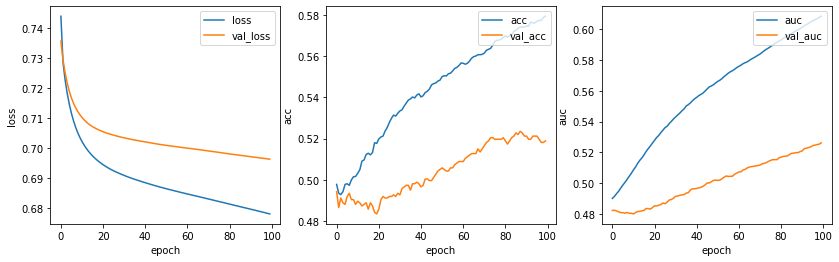

In [18]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [19]:
pred_proba_test, pred_test = eval_metrics(non_rel_mlp)

test set
              precision    recall  f1-score   support

         0.0       0.53      0.52      0.52      2592
         1.0       0.53      0.54      0.53      2592

    accuracy                           0.53      5184
   macro avg       0.53      0.53      0.53      5184
weighted avg       0.53      0.53      0.53      5184



In [29]:
log_to_wandb(y_test, pred_proba_test, pred_test)

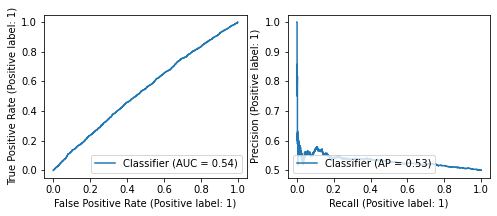

In [31]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

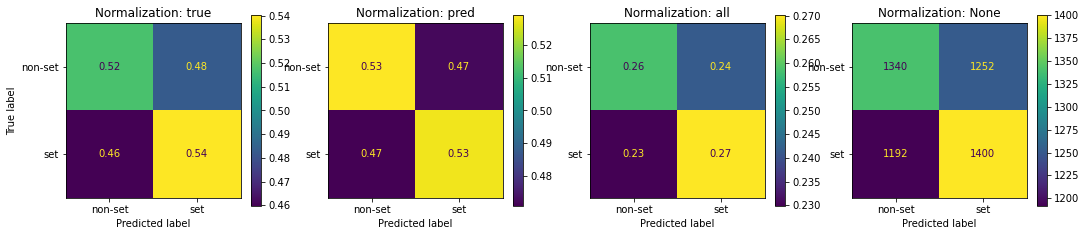

In [33]:
plot_confusion_matrices(y_test[:,1][:,1], pred_test);

In [34]:
wandb.finish()

acc,▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██████
auc,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██████
recall,▁▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_acc,▃▂▂▂▂▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▇█▇▇▇███▇█▇▇
val_auc,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▆▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▂▂▂▂▂▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▄▅▅▅▆▆▆▇█▇▇▇███▇█▇▇


### CoRelNet

In [37]:
def create_corelnet_model(n_entities, base_encoding_dim, encoder_constructor, name='CoRelNet'):
    input_ = tf.keras.layers.Input(shape=(n_entities, base_encoding_dim), name='input_entity_seq')

    if encoder_constructor is not None:
        x = EntityEncoder(encoder_constructor, name='encode_entities')(input_)
    else:
        x = input_

    x = RelInnerProduct(name='relation_inner_prod')(x)

    x = tf.keras.layers.Flatten(name='flatten')(x)

    x = tf.keras.layers.Dense(9, activation='relu', name='dense1')(x)
    
    x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

    corelnet = tf.keras.Model(input_, x, name=name)

    return corelnet

#### CoRelNet: No Encoder

In [38]:
encoder_constructor = None

corelnet = create_corelnet_model(n_entities=3, base_encoding_dim=12, encoder_constructor=encoder_constructor)
corelnet.compile(loss=loss, optimizer=opt, metrics=metrics)
corelnet.summary()

Model: "CoRelNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
relation_inner_prod (RelInne (None, 3, 3)              0         
_________________________________________________________________
flatten (Flatten)            (None, 9)                 0         
_________________________________________________________________
dense1 (Dense)               (None, 9)                 90        
_________________________________________________________________
output (Dense)               (None, 2)                 20        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [39]:
run = wandb.init(project='RelNN', group='CoRelNet (no encoder)', save_code=True)
history = corelnet.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

2022-10-26 20:27:21.932869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 20:27:21.933345: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-10-26 20:27:21.933493: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-26 20:27:21.934182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 20:27:21.934699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 20:27:21.935200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/100
51/51 [==============================] - 2s 20ms/step - loss: 0.7015 - acc: 0.4758 - precision: 0.4763 - recall: 0.4881 - auc: 0.5449 - val_loss: 0.6795 - val_acc: 0.5335 - val_precision: 0.5313 - val_recall: 0.5747 - val_auc: 0.5725
Epoch 2/100
51/51 [==============================] - 0s 8ms/step - loss: 0.6598 - acc: 0.5623 - precision: 0.5631 - recall: 0.5551 - auc: 0.6337 - val_loss: 0.6624 - val_acc: 0.5698 - val_precision: 0.5695 - val_recall: 0.5747 - val_auc: 0.6226
Epoch 3/100
51/51 [==============================] - 0s 7ms/step - loss: 0.6489 - acc: 0.5990 - precision: 0.6060 - recall: 0.5659 - auc: 0.6583 - val_loss: 0.6542 - val_acc: 0.5775 - val_precision: 0.5783 - val_recall: 0.5747 - val_auc: 0.6233
Epoch 4/100
51/51 [==============================] - 0s 7ms/step - loss: 0.6420 - acc: 0.6104 - precision: 0.6196 - recall: 0.5718 - auc: 0.6748 - val_loss: 0.6474 - val_acc: 0.5906 - val_precision: 0.5939 - val_recall: 0.5747 - val_auc: 0.6705
Epoch 5/100
51/51 [

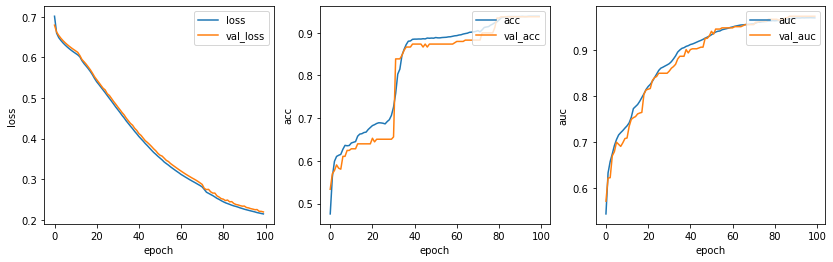

In [40]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [41]:
pred_proba_test, pred_test = eval_metrics(corelnet)

test set
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94      2592
         1.0       0.89      1.00      0.94      2592

    accuracy                           0.94      5184
   macro avg       0.95      0.94      0.94      5184
weighted avg       0.95      0.94      0.94      5184



In [42]:
log_to_wandb(y_test, pred_proba_test, pred_test)

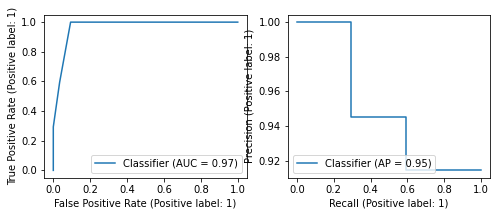

In [43]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

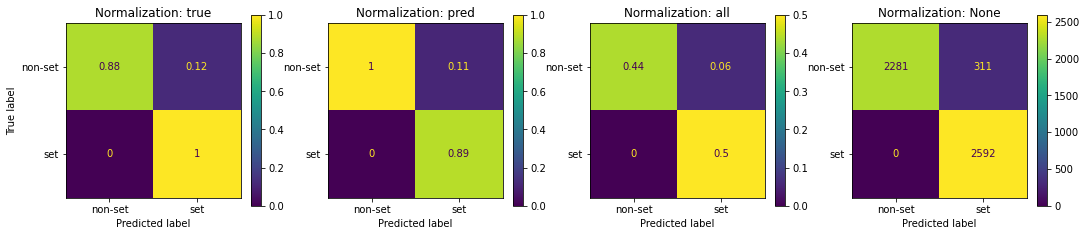

In [46]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [47]:
wandb.finish()

acc,▁▃▃▃▄▄▄▄▄▄▄▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
auc,▁▃▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▃▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
recall,▁▂▂▂▂▂▂▃▃▃▃▃▄▆██████████████████████████
val_acc,▁▂▂▂▃▃▃▃▃▃▃▃▃▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
val_auc,▁▂▃▃▃▄▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇███████████████████
val_loss,██▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_precision,▁▂▂▃▃▃▄▄▄▄▄▄▄▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇████████


#### CoRelNet: MLP Encoder

In [49]:
encoder_constructor = lambda: MLPEncoder([12], activation='relu')

corelnet = create_corelnet_model(n_entities=3, base_encoding_dim=12, encoder_constructor=encoder_constructor)
corelnet.compile(loss=loss, optimizer=opt, metrics=metrics)
corelnet.summary()

Model: "CoRelNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
encode_entities (EntityEncod (None, 3, 12)             156       
_________________________________________________________________
relation_inner_prod (RelInne (None, 3, 3)              0         
_________________________________________________________________
flatten (Flatten)            (None, 9)                 0         
_________________________________________________________________
dense1 (Dense)               (None, 9)                 90        
_________________________________________________________________
output (Dense)               (None, 2)                 20        
Total params: 266
Trainable params: 266
Non-trainable params: 0
____________________________________________________________

In [50]:
run = wandb.init(project='RelNN', group='CoRelNet (MLP encoder)', save_code=True)
history = corelnet.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

2022-10-26 20:32:22.410039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 20:32:22.410516: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-10-26 20:32:22.410666: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-26 20:32:22.411516: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 20:32:22.412040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 20:32:22.412531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/100
51/51 [==============================] - 8s 142ms/step - loss: 0.7616 - acc: 0.5769 - precision: 0.6297 - recall: 0.3735 - auc: 0.6331 - val_loss: 0.7067 - val_acc: 0.5158 - val_precision: 0.5154 - val_recall: 0.5424 - val_auc: 0.5003


wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.
2022-10-26 20:32:42.299159: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 2/100
51/51 [==============================] - 4s 74ms/step - loss: 0.7008 - acc: 0.5150 - precision: 0.5146 - recall: 0.5273 - auc: 0.5124 - val_loss: 0.7027 - val_acc: 0.5166 - val_precision: 0.5152 - val_recall: 0.5763 - val_auc: 0.4992


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 3/100
51/51 [==============================] - 4s 72ms/step - loss: 0.6980 - acc: 0.5158 - precision: 0.5152 - recall: 0.5332 - auc: 0.5139 - val_loss: 0.7003 - val_acc: 0.5173 - val_precision: 0.5159 - val_recall: 0.5763 - val_auc: 0.5001


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 4/100
51/51 [==============================] - 4s 73ms/step - loss: 0.6963 - acc: 0.5160 - precision: 0.5156 - recall: 0.5270 - auc: 0.5150 - val_loss: 0.6987 - val_acc: 0.5181 - val_precision: 0.5167 - val_recall: 0.5732 - val_auc: 0.4988


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 5/100
51/51 [==============================] - 4s 73ms/step - loss: 0.6952 - acc: 0.5174 - precision: 0.5170 - recall: 0.5270 - auc: 0.5164 - val_loss: 0.6976 - val_acc: 0.5150 - val_precision: 0.5139 - val_recall: 0.5701 - val_auc: 0.5015


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 6/100
51/51 [==============================] - 4s 74ms/step - loss: 0.6944 - acc: 0.5197 - precision: 0.5192 - recall: 0.5292 - auc: 0.5179 - val_loss: 0.6967 - val_acc: 0.5204 - val_precision: 0.5186 - val_recall: 0.5794 - val_auc: 0.5012


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 7/100
51/51 [==============================] - 4s 86ms/step - loss: 0.6938 - acc: 0.5172 - precision: 0.5168 - recall: 0.5273 - auc: 0.5193 - val_loss: 0.6960 - val_acc: 0.5189 - val_precision: 0.5172 - val_recall: 0.5778 - val_auc: 0.5030


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 8/100
51/51 [==============================] - 4s 80ms/step - loss: 0.6934 - acc: 0.5172 - precision: 0.5168 - recall: 0.5282 - auc: 0.5203 - val_loss: 0.6954 - val_acc: 0.5181 - val_precision: 0.5166 - val_recall: 0.5763 - val_auc: 0.5047


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 9/100
51/51 [==============================] - 4s 80ms/step - loss: 0.6930 - acc: 0.5181 - precision: 0.5177 - recall: 0.5292 - auc: 0.5222 - val_loss: 0.6949 - val_acc: 0.5243 - val_precision: 0.5221 - val_recall: 0.5824 - val_auc: 0.5047


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 10/100
51/51 [==============================] - 4s 82ms/step - loss: 0.6927 - acc: 0.5177 - precision: 0.5172 - recall: 0.5282 - auc: 0.5228 - val_loss: 0.6945 - val_acc: 0.5212 - val_precision: 0.5192 - val_recall: 0.5824 - val_auc: 0.5080


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 11/100
51/51 [==============================] - 4s 75ms/step - loss: 0.6924 - acc: 0.5201 - precision: 0.5196 - recall: 0.5329 - auc: 0.5241 - val_loss: 0.6941 - val_acc: 0.5243 - val_precision: 0.5219 - val_recall: 0.5871 - val_auc: 0.5097


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 12/100
51/51 [==============================] - 4s 74ms/step - loss: 0.6922 - acc: 0.5226 - precision: 0.5218 - recall: 0.5384 - auc: 0.5256 - val_loss: 0.6937 - val_acc: 0.5204 - val_precision: 0.5182 - val_recall: 0.5917 - val_auc: 0.5119


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 13/100
51/51 [==============================] - 4s 73ms/step - loss: 0.6919 - acc: 0.5259 - precision: 0.5249 - recall: 0.5431 - auc: 0.5274 - val_loss: 0.6934 - val_acc: 0.5189 - val_precision: 0.5167 - val_recall: 0.5963 - val_auc: 0.5144


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 14/100
51/51 [==============================] - 4s 74ms/step - loss: 0.6917 - acc: 0.5276 - precision: 0.5264 - recall: 0.5477 - auc: 0.5287 - val_loss: 0.6931 - val_acc: 0.5220 - val_precision: 0.5194 - val_recall: 0.5994 - val_auc: 0.5172


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 15/100
51/51 [==============================] - 4s 74ms/step - loss: 0.6914 - acc: 0.5299 - precision: 0.5287 - recall: 0.5492 - auc: 0.5301 - val_loss: 0.6927 - val_acc: 0.5204 - val_precision: 0.5179 - val_recall: 0.6025 - val_auc: 0.5208


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 16/100
51/51 [==============================] - 4s 76ms/step - loss: 0.6912 - acc: 0.5330 - precision: 0.5316 - recall: 0.5523 - auc: 0.5309 - val_loss: 0.6924 - val_acc: 0.5212 - val_precision: 0.5186 - val_recall: 0.6025 - val_auc: 0.5216


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 17/100
51/51 [==============================] - 4s 79ms/step - loss: 0.6910 - acc: 0.5323 - precision: 0.5312 - recall: 0.5499 - auc: 0.5327 - val_loss: 0.6921 - val_acc: 0.5212 - val_precision: 0.5186 - val_recall: 0.6025 - val_auc: 0.5231


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 18/100
51/51 [==============================] - 4s 79ms/step - loss: 0.6908 - acc: 0.5323 - precision: 0.5311 - recall: 0.5502 - auc: 0.5350 - val_loss: 0.6918 - val_acc: 0.5274 - val_precision: 0.5237 - val_recall: 0.6117 - val_auc: 0.5257


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 19/100
51/51 [==============================] - 4s 80ms/step - loss: 0.6905 - acc: 0.5323 - precision: 0.5310 - recall: 0.5523 - auc: 0.5366 - val_loss: 0.6915 - val_acc: 0.5305 - val_precision: 0.5265 - val_recall: 0.6133 - val_auc: 0.5300


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 20/100
51/51 [==============================] - 4s 80ms/step - loss: 0.6903 - acc: 0.5330 - precision: 0.5315 - recall: 0.5545 - auc: 0.5380 - val_loss: 0.6911 - val_acc: 0.5320 - val_precision: 0.5278 - val_recall: 0.6148 - val_auc: 0.5336


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 21/100
51/51 [==============================] - 4s 73ms/step - loss: 0.6900 - acc: 0.5348 - precision: 0.5332 - recall: 0.5582 - auc: 0.5394 - val_loss: 0.6908 - val_acc: 0.5328 - val_precision: 0.5285 - val_recall: 0.6148 - val_auc: 0.5360


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 22/100
51/51 [==============================] - 4s 75ms/step - loss: 0.6898 - acc: 0.5363 - precision: 0.5344 - recall: 0.5634 - auc: 0.5412 - val_loss: 0.6905 - val_acc: 0.5351 - val_precision: 0.5303 - val_recall: 0.6194 - val_auc: 0.5377


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 23/100
51/51 [==============================] - 4s 85ms/step - loss: 0.6896 - acc: 0.5384 - precision: 0.5362 - recall: 0.5675 - auc: 0.5428 - val_loss: 0.6902 - val_acc: 0.5397 - val_precision: 0.5343 - val_recall: 0.6240 - val_auc: 0.5396


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 24/100
51/51 [==============================] - 4s 72ms/step - loss: 0.6893 - acc: 0.5414 - precision: 0.5390 - recall: 0.5724 - auc: 0.5444 - val_loss: 0.6898 - val_acc: 0.5436 - val_precision: 0.5375 - val_recall: 0.6302 - val_auc: 0.5408


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 25/100
51/51 [==============================] - 4s 74ms/step - loss: 0.6890 - acc: 0.5407 - precision: 0.5381 - recall: 0.5733 - auc: 0.5466 - val_loss: 0.6895 - val_acc: 0.5474 - val_precision: 0.5410 - val_recall: 0.6302 - val_auc: 0.5447


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 26/100
51/51 [==============================] - 4s 84ms/step - loss: 0.6887 - acc: 0.5422 - precision: 0.5394 - recall: 0.5767 - auc: 0.5480 - val_loss: 0.6891 - val_acc: 0.5528 - val_precision: 0.5456 - val_recall: 0.6364 - val_auc: 0.5471


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 27/100
51/51 [==============================] - 4s 72ms/step - loss: 0.6884 - acc: 0.5445 - precision: 0.5416 - recall: 0.5786 - auc: 0.5499 - val_loss: 0.6887 - val_acc: 0.5536 - val_precision: 0.5461 - val_recall: 0.6394 - val_auc: 0.5504


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 28/100
51/51 [==============================] - 4s 72ms/step - loss: 0.6881 - acc: 0.5462 - precision: 0.5429 - recall: 0.5835 - auc: 0.5521 - val_loss: 0.6883 - val_acc: 0.5590 - val_precision: 0.5505 - val_recall: 0.6471 - val_auc: 0.5534


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 29/100
51/51 [==============================] - 4s 86ms/step - loss: 0.6877 - acc: 0.5481 - precision: 0.5445 - recall: 0.5869 - auc: 0.5546 - val_loss: 0.6878 - val_acc: 0.5621 - val_precision: 0.5534 - val_recall: 0.6471 - val_auc: 0.5569


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 30/100
51/51 [==============================] - 4s 79ms/step - loss: 0.6873 - acc: 0.5464 - precision: 0.5428 - recall: 0.5875 - auc: 0.5571 - val_loss: 0.6872 - val_acc: 0.5644 - val_precision: 0.5547 - val_recall: 0.6564 - val_auc: 0.5599


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 31/100
51/51 [==============================] - 4s 82ms/step - loss: 0.6868 - acc: 0.5468 - precision: 0.5429 - recall: 0.5915 - auc: 0.5598 - val_loss: 0.6866 - val_acc: 0.5667 - val_precision: 0.5557 - val_recall: 0.6687 - val_auc: 0.5634


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 32/100
51/51 [==============================] - 4s 73ms/step - loss: 0.6862 - acc: 0.5532 - precision: 0.5483 - recall: 0.6023 - auc: 0.5627 - val_loss: 0.6859 - val_acc: 0.5667 - val_precision: 0.5553 - val_recall: 0.6733 - val_auc: 0.5684


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 33/100
51/51 [==============================] - 4s 72ms/step - loss: 0.6856 - acc: 0.5539 - precision: 0.5487 - recall: 0.6073 - auc: 0.5663 - val_loss: 0.6852 - val_acc: 0.5675 - val_precision: 0.5554 - val_recall: 0.6795 - val_auc: 0.5697


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 34/100
51/51 [==============================] - 4s 74ms/step - loss: 0.6848 - acc: 0.5572 - precision: 0.5512 - recall: 0.6153 - auc: 0.5713 - val_loss: 0.6843 - val_acc: 0.5636 - val_precision: 0.5518 - val_recall: 0.6810 - val_auc: 0.5731


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 35/100
51/51 [==============================] - 4s 73ms/step - loss: 0.6839 - acc: 0.5623 - precision: 0.5555 - recall: 0.6227 - auc: 0.5753 - val_loss: 0.6833 - val_acc: 0.5659 - val_precision: 0.5537 - val_recall: 0.6826 - val_auc: 0.5796


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 36/100
51/51 [==============================] - 4s 73ms/step - loss: 0.6829 - acc: 0.5666 - precision: 0.5593 - recall: 0.6280 - auc: 0.5815 - val_loss: 0.6822 - val_acc: 0.5713 - val_precision: 0.5581 - val_recall: 0.6888 - val_auc: 0.5840


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 37/100
51/51 [==============================] - 4s 80ms/step - loss: 0.6818 - acc: 0.5737 - precision: 0.5650 - recall: 0.6397 - auc: 0.5862 - val_loss: 0.6810 - val_acc: 0.5759 - val_precision: 0.5612 - val_recall: 0.6995 - val_auc: 0.5900


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 38/100
51/51 [==============================] - 5s 92ms/step - loss: 0.6806 - acc: 0.5772 - precision: 0.5673 - recall: 0.6508 - auc: 0.5940 - val_loss: 0.6798 - val_acc: 0.5798 - val_precision: 0.5636 - val_recall: 0.7103 - val_auc: 0.5958


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 39/100
51/51 [==============================] - 4s 76ms/step - loss: 0.6793 - acc: 0.5837 - precision: 0.5724 - recall: 0.6616 - auc: 0.6005 - val_loss: 0.6783 - val_acc: 0.5844 - val_precision: 0.5684 - val_recall: 0.7042 - val_auc: 0.6036


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 40/100
51/51 [==============================] - 4s 73ms/step - loss: 0.6778 - acc: 0.5864 - precision: 0.5745 - recall: 0.6653 - auc: 0.6079 - val_loss: 0.6767 - val_acc: 0.5906 - val_precision: 0.5723 - val_recall: 0.7196 - val_auc: 0.6108


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 41/100
51/51 [==============================] - 4s 82ms/step - loss: 0.6760 - acc: 0.5973 - precision: 0.5838 - recall: 0.6777 - auc: 0.6164 - val_loss: 0.6748 - val_acc: 0.5937 - val_precision: 0.5749 - val_recall: 0.7211 - val_auc: 0.6185


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 42/100
51/51 [==============================] - 4s 73ms/step - loss: 0.6738 - acc: 0.6021 - precision: 0.5871 - recall: 0.6879 - auc: 0.6260 - val_loss: 0.6726 - val_acc: 0.6052 - val_precision: 0.5834 - val_recall: 0.7381 - val_auc: 0.6271


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 43/100
51/51 [==============================] - 4s 75ms/step - loss: 0.6713 - acc: 0.6083 - precision: 0.5914 - recall: 0.7002 - auc: 0.6374 - val_loss: 0.6700 - val_acc: 0.6168 - val_precision: 0.5911 - val_recall: 0.7596 - val_auc: 0.6401


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 44/100
51/51 [==============================] - 4s 74ms/step - loss: 0.6685 - acc: 0.6209 - precision: 0.6009 - recall: 0.7200 - auc: 0.6501 - val_loss: 0.6670 - val_acc: 0.6199 - val_precision: 0.5926 - val_recall: 0.7689 - val_auc: 0.6536


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 45/100
51/51 [==============================] - 4s 75ms/step - loss: 0.6652 - acc: 0.6327 - precision: 0.6089 - recall: 0.7416 - auc: 0.6639 - val_loss: 0.6633 - val_acc: 0.6330 - val_precision: 0.6021 - val_recall: 0.7858 - val_auc: 0.6695


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 46/100
51/51 [==============================] - 4s 79ms/step - loss: 0.6616 - acc: 0.6408 - precision: 0.6157 - recall: 0.7493 - auc: 0.6783 - val_loss: 0.6592 - val_acc: 0.6484 - val_precision: 0.6150 - val_recall: 0.7951 - val_auc: 0.6858


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 47/100
51/51 [==============================] - 4s 80ms/step - loss: 0.6573 - acc: 0.6537 - precision: 0.6252 - recall: 0.7672 - auc: 0.6935 - val_loss: 0.6545 - val_acc: 0.6554 - val_precision: 0.6202 - val_recall: 0.8028 - val_auc: 0.7026


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 48/100
51/51 [==============================] - 4s 79ms/step - loss: 0.6523 - acc: 0.6675 - precision: 0.6363 - recall: 0.7817 - auc: 0.7105 - val_loss: 0.6493 - val_acc: 0.6677 - val_precision: 0.6298 - val_recall: 0.8151 - val_auc: 0.7191


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 49/100
51/51 [==============================] - 4s 73ms/step - loss: 0.6467 - acc: 0.6782 - precision: 0.6441 - recall: 0.7962 - auc: 0.7287 - val_loss: 0.6434 - val_acc: 0.6816 - val_precision: 0.6411 - val_recall: 0.8259 - val_auc: 0.7364


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 50/100
51/51 [==============================] - 4s 72ms/step - loss: 0.6403 - acc: 0.6935 - precision: 0.6560 - recall: 0.8132 - auc: 0.7477 - val_loss: 0.6365 - val_acc: 0.6985 - val_precision: 0.6562 - val_recall: 0.8351 - val_auc: 0.7556


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 51/100
51/51 [==============================] - 4s 85ms/step - loss: 0.6328 - acc: 0.7104 - precision: 0.6699 - recall: 0.8296 - auc: 0.7674 - val_loss: 0.6284 - val_acc: 0.7116 - val_precision: 0.6675 - val_recall: 0.8444 - val_auc: 0.7749


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 52/100
51/51 [==============================] - 4s 73ms/step - loss: 0.6241 - acc: 0.7291 - precision: 0.6850 - recall: 0.8481 - auc: 0.7879 - val_loss: 0.6187 - val_acc: 0.7379 - val_precision: 0.6896 - val_recall: 0.8659 - val_auc: 0.7970


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 53/100
51/51 [==============================] - 4s 74ms/step - loss: 0.6137 - acc: 0.7452 - precision: 0.6990 - recall: 0.8611 - auc: 0.8092 - val_loss: 0.6073 - val_acc: 0.7579 - val_precision: 0.7050 - val_recall: 0.8875 - val_auc: 0.8177


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 54/100
51/51 [==============================] - 4s 84ms/step - loss: 0.6013 - acc: 0.7656 - precision: 0.7156 - recall: 0.8811 - auc: 0.8309 - val_loss: 0.5937 - val_acc: 0.7833 - val_precision: 0.7266 - val_recall: 0.9091 - val_auc: 0.8372


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 55/100
51/51 [==============================] - 4s 84ms/step - loss: 0.5869 - acc: 0.7870 - precision: 0.7342 - recall: 0.8997 - auc: 0.8493 - val_loss: 0.5778 - val_acc: 0.8088 - val_precision: 0.7509 - val_recall: 0.9245 - val_auc: 0.8546


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 56/100
51/51 [==============================] - 4s 78ms/step - loss: 0.5703 - acc: 0.8103 - precision: 0.7530 - recall: 0.9234 - auc: 0.8637 - val_loss: 0.5597 - val_acc: 0.8250 - val_precision: 0.7611 - val_recall: 0.9476 - val_auc: 0.8664


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 57/100
51/51 [==============================] - 4s 85ms/step - loss: 0.5517 - acc: 0.8239 - precision: 0.7623 - recall: 0.9413 - auc: 0.8736 - val_loss: 0.5396 - val_acc: 0.8358 - val_precision: 0.7691 - val_recall: 0.9599 - val_auc: 0.8748


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 58/100
51/51 [==============================] - 4s 79ms/step - loss: 0.5311 - acc: 0.8361 - precision: 0.7699 - recall: 0.9586 - auc: 0.8805 - val_loss: 0.5178 - val_acc: 0.8427 - val_precision: 0.7717 - val_recall: 0.9738 - val_auc: 0.8809


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 59/100
51/51 [==============================] - 4s 80ms/step - loss: 0.5089 - acc: 0.8412 - precision: 0.7690 - recall: 0.9753 - auc: 0.8854 - val_loss: 0.4950 - val_acc: 0.8481 - val_precision: 0.7736 - val_recall: 0.9846 - val_auc: 0.8858


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 60/100
51/51 [==============================] - 4s 72ms/step - loss: 0.4860 - acc: 0.8424 - precision: 0.7666 - recall: 0.9846 - auc: 0.8895 - val_loss: 0.4719 - val_acc: 0.8473 - val_precision: 0.7707 - val_recall: 0.9892 - val_auc: 0.8903


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 61/100
51/51 [==============================] - 4s 72ms/step - loss: 0.4636 - acc: 0.8436 - precision: 0.7654 - recall: 0.9910 - auc: 0.8931 - val_loss: 0.4499 - val_acc: 0.8458 - val_precision: 0.7682 - val_recall: 0.9908 - val_auc: 0.8943


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 62/100
51/51 [==============================] - 4s 73ms/step - loss: 0.4427 - acc: 0.8432 - precision: 0.7638 - recall: 0.9935 - auc: 0.8962 - val_loss: 0.4297 - val_acc: 0.8473 - val_precision: 0.7675 - val_recall: 0.9969 - val_auc: 0.8976


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 63/100
51/51 [==============================] - 4s 73ms/step - loss: 0.4239 - acc: 0.8429 - precision: 0.7623 - recall: 0.9963 - auc: 0.8992 - val_loss: 0.4120 - val_acc: 0.8458 - val_precision: 0.7657 - val_recall: 0.9969 - val_auc: 0.9007


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 64/100
51/51 [==============================] - 4s 72ms/step - loss: 0.4077 - acc: 0.8441 - precision: 0.7630 - recall: 0.9981 - auc: 0.9021 - val_loss: 0.3968 - val_acc: 0.8458 - val_precision: 0.7644 - val_recall: 1.0000 - val_auc: 0.9035


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 65/100
51/51 [==============================] - 4s 72ms/step - loss: 0.3938 - acc: 0.8452 - precision: 0.7642 - recall: 0.9985 - auc: 0.9047 - val_loss: 0.3839 - val_acc: 0.8466 - val_precision: 0.7653 - val_recall: 1.0000 - val_auc: 0.9061


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 66/100
51/51 [==============================] - 4s 74ms/step - loss: 0.3822 - acc: 0.8470 - precision: 0.7660 - recall: 0.9994 - auc: 0.9072 - val_loss: 0.3730 - val_acc: 0.8466 - val_precision: 0.7653 - val_recall: 1.0000 - val_auc: 0.9088


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 67/100
51/51 [==============================] - 4s 80ms/step - loss: 0.3721 - acc: 0.8477 - precision: 0.7667 - recall: 0.9994 - auc: 0.9102 - val_loss: 0.3637 - val_acc: 0.8466 - val_precision: 0.7653 - val_recall: 1.0000 - val_auc: 0.9117


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 68/100
51/51 [==============================] - 4s 82ms/step - loss: 0.3630 - acc: 0.8492 - precision: 0.7685 - recall: 0.9994 - auc: 0.9138 - val_loss: 0.3554 - val_acc: 0.8466 - val_precision: 0.7653 - val_recall: 1.0000 - val_auc: 0.9151


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 69/100
51/51 [==============================] - 4s 74ms/step - loss: 0.3548 - acc: 0.8518 - precision: 0.7716 - recall: 0.9994 - auc: 0.9175 - val_loss: 0.3479 - val_acc: 0.8497 - val_precision: 0.7690 - val_recall: 1.0000 - val_auc: 0.9185


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 70/100
51/51 [==============================] - 4s 71ms/step - loss: 0.3470 - acc: 0.8551 - precision: 0.7754 - recall: 0.9997 - auc: 0.9214 - val_loss: 0.3407 - val_acc: 0.8512 - val_precision: 0.7708 - val_recall: 1.0000 - val_auc: 0.9218


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 71/100
51/51 [==============================] - 4s 84ms/step - loss: 0.3394 - acc: 0.8585 - precision: 0.7796 - recall: 0.9994 - auc: 0.9256 - val_loss: 0.3336 - val_acc: 0.8543 - val_precision: 0.7745 - val_recall: 1.0000 - val_auc: 0.9260


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 72/100
51/51 [==============================] - 4s 74ms/step - loss: 0.3315 - acc: 0.8616 - precision: 0.7834 - recall: 0.9994 - auc: 0.9306 - val_loss: 0.3267 - val_acc: 0.8558 - val_precision: 0.7763 - val_recall: 1.0000 - val_auc: 0.9307


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 73/100
51/51 [==============================] - 4s 79ms/step - loss: 0.3231 - acc: 0.8657 - precision: 0.7886 - recall: 0.9994 - auc: 0.9357 - val_loss: 0.3188 - val_acc: 0.8620 - val_precision: 0.7838 - val_recall: 1.0000 - val_auc: 0.9355


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 74/100
51/51 [==============================] - 4s 79ms/step - loss: 0.3142 - acc: 0.8702 - precision: 0.7942 - recall: 0.9994 - auc: 0.9411 - val_loss: 0.3116 - val_acc: 0.8635 - val_precision: 0.7857 - val_recall: 1.0000 - val_auc: 0.9392


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 75/100
51/51 [==============================] - 4s 77ms/step - loss: 0.3049 - acc: 0.8756 - precision: 0.8010 - recall: 0.9994 - auc: 0.9457 - val_loss: 0.3043 - val_acc: 0.8651 - val_precision: 0.7876 - val_recall: 1.0000 - val_auc: 0.9422


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 76/100
51/51 [==============================] - 4s 73ms/step - loss: 0.2950 - acc: 0.8829 - precision: 0.8105 - recall: 0.9994 - auc: 0.9497 - val_loss: 0.2948 - val_acc: 0.8697 - val_precision: 0.7934 - val_recall: 1.0000 - val_auc: 0.9449


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 77/100
51/51 [==============================] - 4s 74ms/step - loss: 0.2845 - acc: 0.8929 - precision: 0.8239 - recall: 0.9994 - auc: 0.9528 - val_loss: 0.2866 - val_acc: 0.8743 - val_precision: 0.7993 - val_recall: 1.0000 - val_auc: 0.9467


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 78/100
51/51 [==============================] - 4s 72ms/step - loss: 0.2739 - acc: 0.9028 - precision: 0.8373 - recall: 0.9997 - auc: 0.9547 - val_loss: 0.2783 - val_acc: 0.8805 - val_precision: 0.8072 - val_recall: 1.0000 - val_auc: 0.9478


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 79/100
51/51 [==============================] - 4s 73ms/step - loss: 0.2634 - acc: 0.9146 - precision: 0.8542 - recall: 1.0000 - auc: 0.9557 - val_loss: 0.2688 - val_acc: 0.8959 - val_precision: 0.8278 - val_recall: 1.0000 - val_auc: 0.9481


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 80/100
51/51 [==============================] - 4s 87ms/step - loss: 0.2532 - acc: 0.9261 - precision: 0.8712 - recall: 1.0000 - auc: 0.9562 - val_loss: 0.2613 - val_acc: 0.9044 - val_precision: 0.8396 - val_recall: 1.0000 - val_auc: 0.9483


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 81/100
51/51 [==============================] - 4s 80ms/step - loss: 0.2435 - acc: 0.9359 - precision: 0.8864 - recall: 1.0000 - auc: 0.9565 - val_loss: 0.2535 - val_acc: 0.9121 - val_precision: 0.8506 - val_recall: 1.0000 - val_auc: 0.9483


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 82/100
51/51 [==============================] - 4s 79ms/step - loss: 0.2345 - acc: 0.9427 - precision: 0.8972 - recall: 1.0000 - auc: 0.9568 - val_loss: 0.2454 - val_acc: 0.9244 - val_precision: 0.8688 - val_recall: 1.0000 - val_auc: 0.9484


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 83/100
51/51 [==============================] - 4s 75ms/step - loss: 0.2263 - acc: 0.9463 - precision: 0.9030 - recall: 1.0000 - auc: 0.9569 - val_loss: 0.2374 - val_acc: 0.9306 - val_precision: 0.8782 - val_recall: 1.0000 - val_auc: 0.9484


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 84/100
51/51 [==============================] - 4s 75ms/step - loss: 0.2189 - acc: 0.9484 - precision: 0.9065 - recall: 1.0000 - auc: 0.9571 - val_loss: 0.2312 - val_acc: 0.9399 - val_precision: 0.8927 - val_recall: 1.0000 - val_auc: 0.9487


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 85/100
51/51 [==============================] - 4s 74ms/step - loss: 0.2125 - acc: 0.9491 - precision: 0.9075 - recall: 1.0000 - auc: 0.9573 - val_loss: 0.2265 - val_acc: 0.9414 - val_precision: 0.8952 - val_recall: 1.0000 - val_auc: 0.9485


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 86/100
51/51 [==============================] - 4s 74ms/step - loss: 0.2068 - acc: 0.9492 - precision: 0.9078 - recall: 1.0000 - auc: 0.9576 - val_loss: 0.2220 - val_acc: 0.9437 - val_precision: 0.8989 - val_recall: 1.0000 - val_auc: 0.9491


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 87/100
51/51 [==============================] - 4s 78ms/step - loss: 0.2018 - acc: 0.9494 - precision: 0.9080 - recall: 1.0000 - auc: 0.9579 - val_loss: 0.2183 - val_acc: 0.9453 - val_precision: 0.9014 - val_recall: 1.0000 - val_auc: 0.9494


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 88/100
51/51 [==============================] - 4s 78ms/step - loss: 0.1978 - acc: 0.9494 - precision: 0.9080 - recall: 1.0000 - auc: 0.9581 - val_loss: 0.2141 - val_acc: 0.9460 - val_precision: 0.9026 - val_recall: 1.0000 - val_auc: 0.9499


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 89/100
51/51 [==============================] - 4s 81ms/step - loss: 0.1940 - acc: 0.9497 - precision: 0.9086 - recall: 1.0000 - auc: 0.9583 - val_loss: 0.2114 - val_acc: 0.9460 - val_precision: 0.9026 - val_recall: 1.0000 - val_auc: 0.9501


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 90/100
51/51 [==============================] - 4s 71ms/step - loss: 0.1906 - acc: 0.9498 - precision: 0.9088 - recall: 1.0000 - auc: 0.9590 - val_loss: 0.2085 - val_acc: 0.9460 - val_precision: 0.9026 - val_recall: 1.0000 - val_auc: 0.9507


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 91/100
51/51 [==============================] - 4s 73ms/step - loss: 0.1879 - acc: 0.9498 - precision: 0.9088 - recall: 1.0000 - auc: 0.9594 - val_loss: 0.2066 - val_acc: 0.9460 - val_precision: 0.9026 - val_recall: 1.0000 - val_auc: 0.9511


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 92/100
51/51 [==============================] - 4s 82ms/step - loss: 0.1851 - acc: 0.9498 - precision: 0.9088 - recall: 1.0000 - auc: 0.9599 - val_loss: 0.2056 - val_acc: 0.9460 - val_precision: 0.9026 - val_recall: 1.0000 - val_auc: 0.9521


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 93/100
51/51 [==============================] - 4s 74ms/step - loss: 0.1827 - acc: 0.9498 - precision: 0.9088 - recall: 1.0000 - auc: 0.9604 - val_loss: 0.2050 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9528


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 94/100
51/51 [==============================] - 4s 73ms/step - loss: 0.1807 - acc: 0.9498 - precision: 0.9088 - recall: 1.0000 - auc: 0.9607 - val_loss: 0.2029 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9536


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 95/100
51/51 [==============================] - 4s 74ms/step - loss: 0.1790 - acc: 0.9498 - precision: 0.9088 - recall: 1.0000 - auc: 0.9611 - val_loss: 0.2010 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9545


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 96/100
51/51 [==============================] - 4s 78ms/step - loss: 0.1776 - acc: 0.9498 - precision: 0.9088 - recall: 1.0000 - auc: 0.9615 - val_loss: 0.1992 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9552


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 97/100
51/51 [==============================] - 4s 78ms/step - loss: 0.1766 - acc: 0.9498 - precision: 0.9088 - recall: 1.0000 - auc: 0.9619 - val_loss: 0.1937 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9562


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 98/100
51/51 [==============================] - 4s 79ms/step - loss: 0.1745 - acc: 0.9500 - precision: 0.9091 - recall: 1.0000 - auc: 0.9626 - val_loss: 0.1934 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9567


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 99/100
51/51 [==============================] - 4s 80ms/step - loss: 0.1727 - acc: 0.9500 - precision: 0.9091 - recall: 1.0000 - auc: 0.9632 - val_loss: 0.1915 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9583


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


Epoch 100/100
51/51 [==============================] - 4s 75ms/step - loss: 0.1709 - acc: 0.9500 - precision: 0.9091 - recall: 1.0000 - auc: 0.9642 - val_loss: 0.1887 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9592


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_203204-22q8o67d/files/model-best)... Done. 0.1s


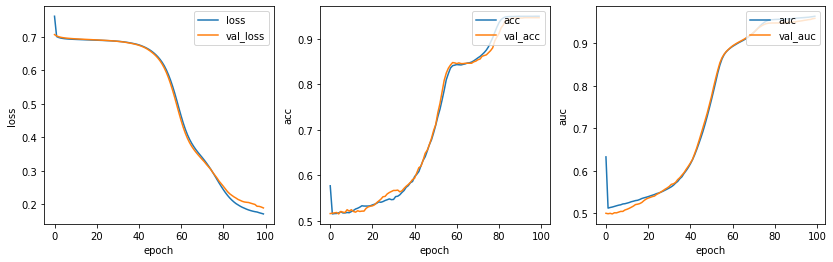

In [51]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [52]:
pred_proba_test, pred_test = eval_metrics(corelnet)

test set
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95      2592
         1.0       0.91      1.00      0.95      2592

    accuracy                           0.95      5184
   macro avg       0.95      0.95      0.95      5184
weighted avg       0.95      0.95      0.95      5184



In [53]:
log_to_wandb(y_test, pred_proba_test, pred_test)

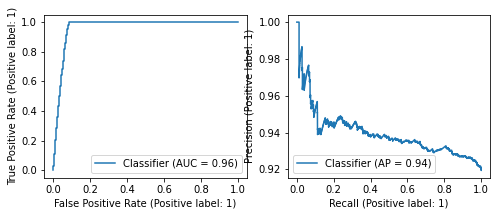

In [54]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

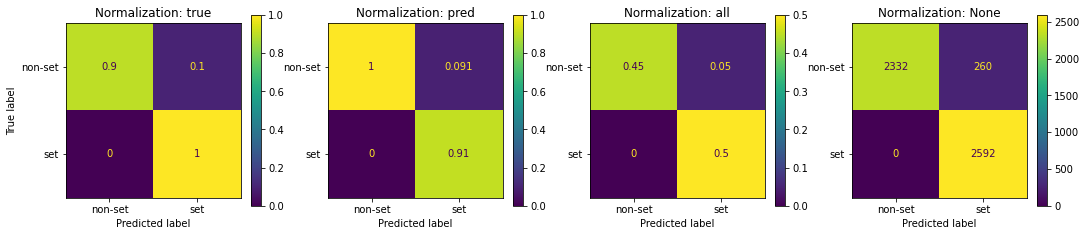

In [55]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [56]:
wandb.finish()

acc,▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▅▆▆▆▆▆▆▇▇▇▇████████
auc,▃▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▄▄▅▆▆▇▇▇▇▇▇███████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▃▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▅▅▆▅▅▅▆▆▆▆▇████████
recall,▁▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▆▆▇▇█████████████████
val_acc,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▄▄▅▆▆▆▆▆▆▇▇▇▇████████
val_auc,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▅▅▆▇▇▇▇▇▇████████████
val_loss,█████████████████▇▇▇▇▆▆▅▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁
val_precision,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▅▅▆▆▅▆▆▆▆▆▇▇███████


## Relational Neural Network (RelNN) [our model]

#### RelNN: Linear Projection Encoders with fixed good initialization of projection spaces

In [58]:
## RelNN with LinearProjectionEncoder
input_ = tf.keras.layers.Input(shape=(3,12), name='input_entity_seq')

encoder_constructors = [LinearProjectionEncoder]*4
rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')
# rel_layer.trainable = False

x = rel_layer(input_)

x = tf.keras.layers.Flatten(name='flatten')(x)

x = tf.keras.layers.Dense(16, activation='relu', name='dense')(x)

x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

relnn = tf.keras.models.Model(input_, x, name='relnn')
relnn.summary()

Model: "relnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
rel_layer (RelationalLayer)  (None, 3, 3, 4)           48        
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                592       
_________________________________________________________________
output (Dense)               (None, 2)                 34        
Total params: 674
Trainable params: 674
Non-trainable params: 0
_________________________________________________________________


In [59]:
# fix projection vectors
init_proj_vecs = [[1]*3+[0]*9, [0]*3+[1]*3+[0]*6, [0]*6+[1]*3+[0]*3, [0]*9+[1]*3]

for encoder, init_proj_vec in zip(rel_layer.entity_encoders, init_proj_vecs):
    encoder.encoder.weights[0].assign(np.array(init_proj_vec, dtype='float'))

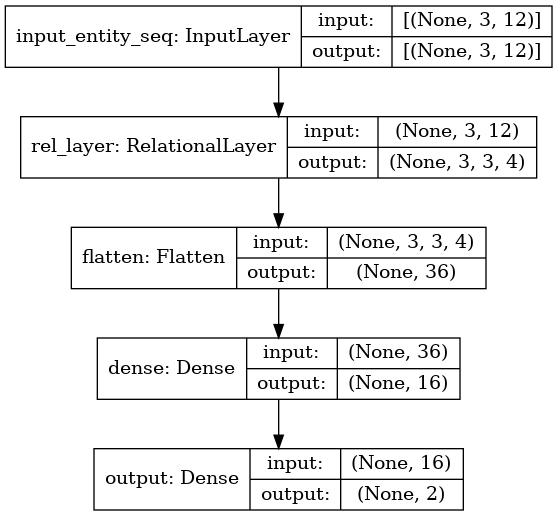

In [60]:
tf.keras.utils.plot_model(relnn, to_file='relnn_architecture.png', expand_nested=True, show_shapes=True)

In [61]:
relnn.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=metrics
    )

In [62]:
run = wandb.init(project='RelNN', group='RelNN (Linear Projection, fixed good init)', save_code=True)
history = relnn.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

2022-10-26 21:14:30.867303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 21:14:30.867802: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-10-26 21:14:30.868004: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-26 21:14:30.868820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 21:14:30.869365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 21:14:30.869872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/100
51/51 [==============================] - 31s 525ms/step - loss: 0.6942 - acc: 0.5725 - precision: 0.5710 - recall: 0.5833 - auc: 0.6395 - val_loss: 0.6936 - val_acc: 0.4942 - val_precision: 0.4973 - val_recall: 0.9784 - val_auc: 0.5054


wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 2/100
51/51 [==============================] - 17s 336ms/step - loss: 0.6932 - acc: 0.5073 - precision: 0.5078 - recall: 0.4714 - auc: 0.5133 - val_loss: 0.6954 - val_acc: 0.5004 - val_precision: 0.5004 - val_recall: 1.0000 - val_auc: 0.4972
Epoch 3/100
51/51 [==============================] - 17s 342ms/step - loss: 0.6931 - acc: 0.5061 - precision: 0.5073 - recall: 0.4168 - auc: 0.5121 - val_loss: 0.6953 - val_acc: 0.5004 - val_precision: 0.5004 - val_recall: 1.0000 - val_auc: 0.5072
Epoch 4/100
51/51 [==============================] - 17s 334ms/step - loss: 0.6893 - acc: 0.5354 - precision: 0.5357 - recall: 0.5304 - auc: 0.5510 - val_loss: 0.6822 - val_acc: 0.5559 - val_precision: 0.5546 - val_recall: 0.5716 - val_auc: 0.5910


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 5/100
51/51 [==============================] - 17s 333ms/step - loss: 0.6579 - acc: 0.6072 - precision: 0.6240 - recall: 0.5391 - auc: 0.6424 - val_loss: 0.6396 - val_acc: 0.6014 - val_precision: 0.6325 - val_recall: 0.4854 - val_auc: 0.6416


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 6/100
51/51 [==============================] - 17s 334ms/step - loss: 0.6178 - acc: 0.6217 - precision: 0.6616 - recall: 0.4980 - auc: 0.6869 - val_loss: 0.5501 - val_acc: 0.6831 - val_precision: 0.7500 - val_recall: 0.5501 - val_auc: 0.8197


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 7/100
51/51 [==============================] - 17s 338ms/step - loss: 0.4535 - acc: 0.7909 - precision: 0.7535 - recall: 0.8645 - auc: 0.8351 - val_loss: 0.3988 - val_acc: 0.8342 - val_precision: 0.7523 - val_recall: 0.9969 - val_auc: 0.8309


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 8/100
51/51 [==============================] - 17s 334ms/step - loss: 0.3971 - acc: 0.8299 - precision: 0.7479 - recall: 0.9954 - auc: 0.8367 - val_loss: 0.3860 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8315


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 9/100
51/51 [==============================] - 17s 331ms/step - loss: 0.3888 - acc: 0.8301 - precision: 0.7477 - recall: 0.9963 - auc: 0.8388 - val_loss: 0.3857 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8293


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 10/100
51/51 [==============================] - 18s 345ms/step - loss: 0.3905 - acc: 0.8281 - precision: 0.7480 - recall: 0.9895 - auc: 0.8353 - val_loss: 0.3861 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8357
Epoch 11/100
51/51 [==============================] - 18s 344ms/step - loss: 0.3873 - acc: 0.8284 - precision: 0.7472 - recall: 0.9926 - auc: 0.8386 - val_loss: 0.3862 - val_acc: 0.8350 - val_precision: 0.7526 - val_recall: 0.9985 - val_auc: 0.8318
Epoch 12/100
51/51 [==============================] - 17s 338ms/step - loss: 0.3864 - acc: 0.8296 - precision: 0.7479 - recall: 0.9944 - auc: 0.8380 - val_loss: 0.3835 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8354


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 13/100
51/51 [==============================] - 17s 342ms/step - loss: 0.3866 - acc: 0.8265 - precision: 0.7470 - recall: 0.9873 - auc: 0.8396 - val_loss: 0.3817 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8367


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 14/100
51/51 [==============================] - 17s 337ms/step - loss: 0.3832 - acc: 0.8311 - precision: 0.7484 - recall: 0.9975 - auc: 0.8384 - val_loss: 0.3798 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8365


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 15/100
51/51 [==============================] - 16s 323ms/step - loss: 0.3822 - acc: 0.8302 - precision: 0.7476 - recall: 0.9969 - auc: 0.8430 - val_loss: 0.3797 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8372


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 16/100
51/51 [==============================] - 17s 340ms/step - loss: 0.3815 - acc: 0.8310 - precision: 0.7488 - recall: 0.9960 - auc: 0.8460 - val_loss: 0.3849 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8325
Epoch 17/100
51/51 [==============================] - 16s 322ms/step - loss: 0.3834 - acc: 0.8305 - precision: 0.7490 - recall: 0.9941 - auc: 0.8401 - val_loss: 0.3847 - val_acc: 0.8365 - val_precision: 0.7538 - val_recall: 1.0000 - val_auc: 0.8287
Epoch 18/100
51/51 [==============================] - 16s 323ms/step - loss: 0.3828 - acc: 0.8302 - precision: 0.7487 - recall: 0.9941 - auc: 0.8435 - val_loss: 0.3852 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8329
Epoch 19/100
51/51 [==============================] - 17s 329ms/step - loss: 0.3835 - acc: 0.8290 - precision: 0.7477 - recall: 0.9929 - auc: 0.8416 - val_loss: 0.3809 - val_acc: 0.8365 - val_precision: 0.7538 - val_recall: 1.0000 - val_auc: 0.8355
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 22/100
51/51 [==============================] - 17s 340ms/step - loss: 0.3745 - acc: 0.8318 - precision: 0.7482 - recall: 1.0000 - auc: 0.8517 - val_loss: 0.3744 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8508
Epoch 23/100
51/51 [==============================] - 17s 341ms/step - loss: 0.3744 - acc: 0.8318 - precision: 0.7482 - recall: 1.0000 - auc: 0.8528 - val_loss: 0.3746 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8511
Epoch 24/100
51/51 [==============================] - 17s 337ms/step - loss: 0.3742 - acc: 0.8318 - precision: 0.7482 - recall: 1.0000 - auc: 0.8532 - val_loss: 0.3746 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8485
Epoch 25/100
51/51 [==============================] - 17s 335ms/step - loss: 0.3741 - acc: 0.8318 - precision: 0.7482 - recall: 1.0000 - auc: 0.8526 - val_loss: 0.3745 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8490
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 29/100
51/51 [==============================] - 17s 330ms/step - loss: 0.3731 - acc: 0.8318 - precision: 0.7482 - recall: 1.0000 - auc: 0.8555 - val_loss: 0.3744 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8482


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 30/100
51/51 [==============================] - 17s 333ms/step - loss: 0.3731 - acc: 0.8318 - precision: 0.7482 - recall: 1.0000 - auc: 0.8552 - val_loss: 0.3743 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8483


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 31/100
51/51 [==============================] - 17s 330ms/step - loss: 0.3731 - acc: 0.8318 - precision: 0.7482 - recall: 1.0000 - auc: 0.8550 - val_loss: 0.3743 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8484

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_211412-1ykvw3ad/files/model-best)... Done. 0.1s


Epoch 32/100
51/51 [==============================] - 17s 329ms/step - loss: 0.3730 - acc: 0.8318 - precision: 0.7482 - recall: 1.0000 - auc: 0.8553 - val_loss: 0.3743 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8483
Epoch 33/100
51/51 [==============================] - 17s 330ms/step - loss: 0.3730 - acc: 0.8318 - precision: 0.7482 - recall: 1.0000 - auc: 0.8552 - val_loss: 0.3743 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8483
Epoch 34/100
51/51 [==============================] - 17s 329ms/step - loss: 0.3730 - acc: 0.8318 - precision: 0.7482 - recall: 1.0000 - auc: 0.8553 - val_loss: 0.3743 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8481
Epoch 35/100
51/51 [==============================] - 17s 324ms/step - loss: 0.3730 - acc: 0.8318 - precision: 0.7482 - recall: 1.0000 - auc: 0.8553 - val_loss: 0.3743 - val_acc: 0.8358 - val_precision: 0.7529 - val_recall: 1.0000 - val_auc: 0.8481
Epoc

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


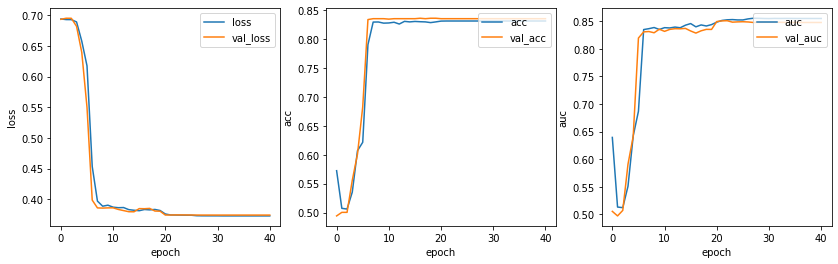

In [63]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [64]:
pred_proba_test, pred_test = eval_metrics(relnn)

test set
              precision    recall  f1-score   support

         0.0       1.00      0.68      0.81      2592
         1.0       0.76      1.00      0.86      2592

    accuracy                           0.84      5184
   macro avg       0.88      0.84      0.83      5184
weighted avg       0.88      0.84      0.83      5184



In [65]:
log_to_wandb(y_test, pred_proba_test, pred_test)

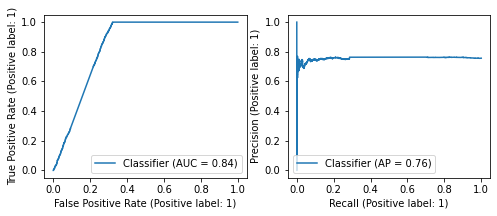

In [66]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

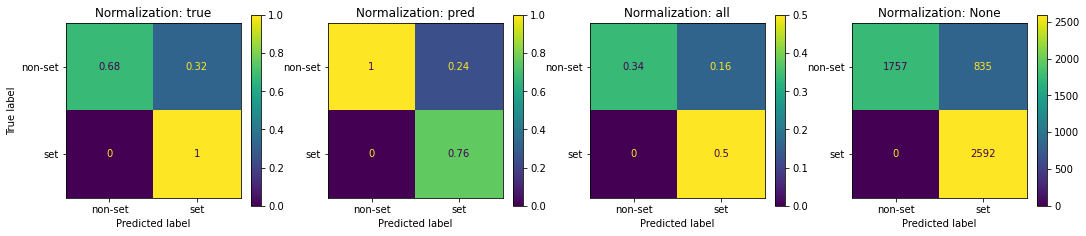

In [67]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [68]:
wandb.finish()

acc,▂▁▁▂▃▃▇█████████████████████████████████
auc,▄▁▁▂▄▅██████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,████▇▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,████████████████████▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▃▁▁▂▄▅██████████████████████████████████
recall,▃▂▁▂▂▂▆█████████████████████████████████
val_acc,▁▁▁▂▃▅██████████████████████████████████
val_auc,▁▁▁▃▄▇██████████████████████████████████
val_loss,████▇▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▁▁▃▅███████████████████████████████████


#### RelNN: Linear Projection Encoders with randomly initialized projection spaces

In [69]:
## RelNN with LinearProjectionEncoder
input_ = tf.keras.layers.Input(shape=(3,12), name='input_entity_seq')

encoder_constructors = [LinearProjectionEncoder]*4
rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')

x = rel_layer(input_)

x = tf.keras.layers.Flatten(name='flatten')(x)

x = tf.keras.layers.Dense(16, activation='relu', name='dense')(x)

x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

relnn = tf.keras.models.Model(input_, x, name='relnn')
relnn.summary()

Model: "relnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
rel_layer (RelationalLayer)  (None, 3, 3, 4)           48        
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                592       
_________________________________________________________________
output (Dense)               (None, 2)                 34        
Total params: 674
Trainable params: 674
Non-trainable params: 0
_________________________________________________________________


In [70]:
relnn.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=metrics
    )

In [71]:
run = wandb.init(project='RelNN', group='RelNN (Linear Projection)', save_code=True)
history = relnn.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

2022-10-26 21:42:13.240517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 21:42:13.241045: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-10-26 21:42:13.241220: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-26 21:42:13.241957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 21:42:13.242474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 21:42:13.242972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/100
51/51 [==============================] - 30s 512ms/step - loss: 0.5948 - acc: 0.6973 - precision: 0.6743 - recall: 0.7631 - auc: 0.7762 - val_loss: 0.3869 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8450


wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_214155-1ngcakau/files/model-best)... Done. 0.1s


Epoch 2/100
51/51 [==============================] - 17s 328ms/step - loss: 0.3882 - acc: 0.8378 - precision: 0.7552 - recall: 0.9994 - auc: 0.8344 - val_loss: 0.3650 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8534


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_214155-1ngcakau/files/model-best)... Done. 0.1s


Epoch 3/100
51/51 [==============================] - 17s 325ms/step - loss: 0.3816 - acc: 0.8370 - precision: 0.7557 - recall: 0.9960 - auc: 0.8372 - val_loss: 0.3682 - val_acc: 0.8404 - val_precision: 0.7631 - val_recall: 0.9877 - val_auc: 0.8562
Epoch 4/100
51/51 [==============================] - 17s 341ms/step - loss: 0.3798 - acc: 0.8379 - precision: 0.7559 - recall: 0.9981 - auc: 0.8368 - val_loss: 0.3646 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8474


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_214155-1ngcakau/files/model-best)... Done. 0.1s


Epoch 5/100
51/51 [==============================] - 17s 336ms/step - loss: 0.3770 - acc: 0.8376 - precision: 0.7554 - recall: 0.9985 - auc: 0.8400 - val_loss: 0.3641 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8459


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_214155-1ngcakau/files/model-best)... Done. 0.1s


Epoch 6/100
51/51 [==============================] - 17s 328ms/step - loss: 0.3771 - acc: 0.8379 - precision: 0.7558 - recall: 0.9985 - auc: 0.8387 - val_loss: 0.3646 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8452
Epoch 7/100
51/51 [==============================] - 16s 321ms/step - loss: 0.3755 - acc: 0.8373 - precision: 0.7552 - recall: 0.9981 - auc: 0.8429 - val_loss: 0.3644 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8468
Epoch 8/100
51/51 [==============================] - 17s 341ms/step - loss: 0.3752 - acc: 0.8381 - precision: 0.7557 - recall: 0.9991 - auc: 0.8430 - val_loss: 0.3643 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8424
Epoch 9/100
51/51 [==============================] - 17s 333ms/step - loss: 0.3753 - acc: 0.8364 - precision: 0.7551 - recall: 0.9957 - auc: 0.8449 - val_loss: 0.3658 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8442
Epoch 10

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_214155-1ngcakau/files/model-best)... Done. 0.1s


Epoch 12/100
51/51 [==============================] - 17s 328ms/step - loss: 0.3663 - acc: 0.8381 - precision: 0.7554 - recall: 1.0000 - auc: 0.8571 - val_loss: 0.3622 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8485


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_214155-1ngcakau/files/model-best)... Done. 0.1s


Epoch 13/100
51/51 [==============================] - 16s 322ms/step - loss: 0.3659 - acc: 0.8381 - precision: 0.7554 - recall: 1.0000 - auc: 0.8583 - val_loss: 0.3623 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8485
Epoch 14/100
51/51 [==============================] - 17s 336ms/step - loss: 0.3655 - acc: 0.8381 - precision: 0.7554 - recall: 1.0000 - auc: 0.8590 - val_loss: 0.3625 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8488
Epoch 15/100
51/51 [==============================] - 17s 337ms/step - loss: 0.3653 - acc: 0.8381 - precision: 0.7554 - recall: 1.0000 - auc: 0.8598 - val_loss: 0.3626 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8489
Epoch 16/100
51/51 [==============================] - 17s 332ms/step - loss: 0.3650 - acc: 0.8381 - precision: 0.7554 - recall: 1.0000 - auc: 0.8604 - val_loss: 0.3628 - val_acc: 0.8443 - val_precision: 0.7626 - val_recall: 1.0000 - val_auc: 0.8477
Epoc

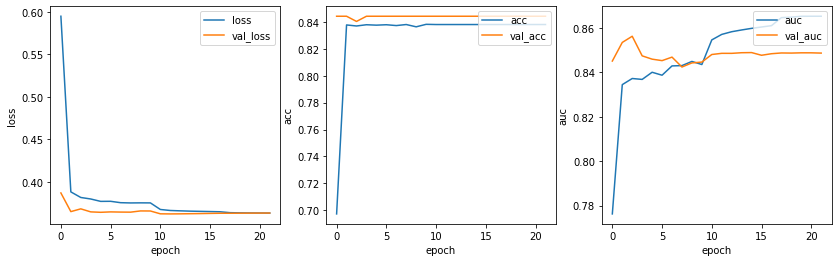

In [72]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [74]:
pred_proba_test, pred_test = eval_metrics(relnn)

test set
              precision    recall  f1-score   support

         0.0       1.00      0.68      0.81      2592
         1.0       0.76      1.00      0.86      2592

    accuracy                           0.84      5184
   macro avg       0.88      0.84      0.84      5184
weighted avg       0.88      0.84      0.84      5184



In [75]:
log_to_wandb(y_test, pred_proba_test, pred_test)

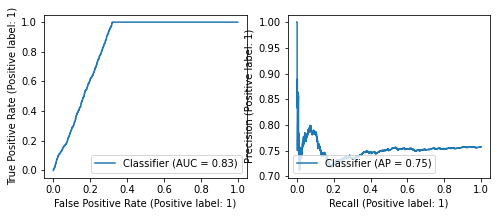

In [76]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

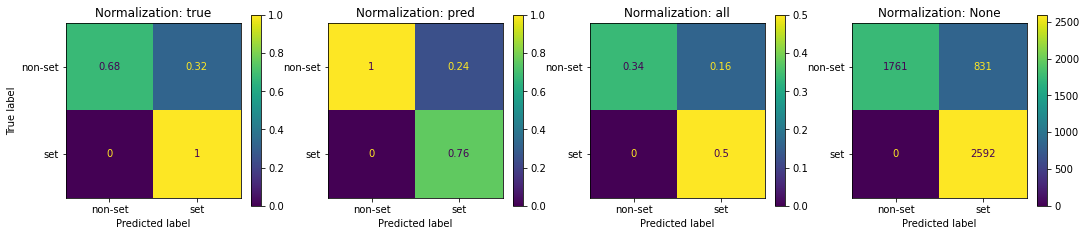

In [77]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [78]:
wandb.finish()

acc,▁█████████████████████
auc,▁▆▆▆▆▆▆▆▆▆▇▇▇█████████
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,██████████▂▂▂▂▂▂▂▁▁▁▁▁
precision,▁█████████████████████
recall,▁█████████████████████
val_acc,██▁███████████████████
val_auc,▂▇█▄▃▂▃▁▂▂▄▄▄▄▄▄▄▄▄▄▄▄
val_loss,█▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


### RelNN: MLP Encoder

In [79]:
## RelNN with LinearProjectionEncoder
input_ = tf.keras.layers.Input(shape=(3,12), name='input_entity_seq')

encoder_constructors = [lambda: MLPEncoder(layer_sizes=(4,), activation='relu')]*4
rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')

x = rel_layer(input_)

x = tf.keras.layers.Flatten(name='flatten')(x)

x = tf.keras.layers.Dense(16, activation='relu', name='dense')(x)

x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

relnn = tf.keras.models.Model(input_, x, name='relnn')
relnn.summary()

Model: "relnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_entity_seq (InputLayer [(None, 3, 12)]           0         
_________________________________________________________________
rel_layer (RelationalLayer)  (None, 3, 3, 4)           208       
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                592       
_________________________________________________________________
output (Dense)               (None, 2)                 34        
Total params: 834
Trainable params: 834
Non-trainable params: 0
_________________________________________________________________


In [80]:
relnn.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=metrics
    )

In [82]:
run = wandb.init(project='RelNN', group='RelNN (MLP enc)', save_code=True)
history = relnn.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), **fit_kwargs)

2022-10-26 22:30:55.102187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 22:30:55.102657: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-10-26 22:30:55.102854: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-26 22:30:55.103702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 22:30:55.104240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 22:30:55.104694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/100
51/51 [==============================] - 23s 382ms/step - loss: 0.7097 - acc: 0.5580 - precision: 0.5579 - recall: 0.5592 - auc: 0.6034 - val_loss: 0.6901 - val_acc: 0.5312 - val_precision: 0.5179 - val_recall: 0.9122 - val_auc: 0.5657


wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 2/100
51/51 [==============================] - 12s 226ms/step - loss: 0.6755 - acc: 0.5757 - precision: 0.5686 - recall: 0.6274 - auc: 0.6087 - val_loss: 0.6285 - val_acc: 0.6430 - val_precision: 0.6247 - val_recall: 0.7180 - val_auc: 0.6889


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 3/100
51/51 [==============================] - 11s 225ms/step - loss: 0.5256 - acc: 0.7260 - precision: 0.6996 - recall: 0.7922 - auc: 0.7984 - val_loss: 0.3677 - val_acc: 0.8527 - val_precision: 0.7966 - val_recall: 0.9476 - val_auc: 0.8691


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 4/100
51/51 [==============================] - 12s 228ms/step - loss: 0.3558 - acc: 0.8572 - precision: 0.7938 - recall: 0.9651 - auc: 0.8834 - val_loss: 0.3438 - val_acc: 0.8674 - val_precision: 0.8046 - val_recall: 0.9707 - val_auc: 0.8747


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 5/100
51/51 [==============================] - 12s 234ms/step - loss: 0.3416 - acc: 0.8640 - precision: 0.7959 - recall: 0.9790 - auc: 0.8862 - val_loss: 0.3401 - val_acc: 0.8766 - val_precision: 0.8022 - val_recall: 1.0000 - val_auc: 0.8761


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 6/100
51/51 [==============================] - 12s 232ms/step - loss: 0.3299 - acc: 0.8702 - precision: 0.7966 - recall: 0.9941 - auc: 0.8880 - val_loss: 0.3181 - val_acc: 0.8766 - val_precision: 0.8022 - val_recall: 1.0000 - val_auc: 0.8889


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 7/100
51/51 [==============================] - 11s 225ms/step - loss: 0.3229 - acc: 0.8694 - precision: 0.7955 - recall: 0.9944 - auc: 0.8941 - val_loss: 0.3235 - val_acc: 0.8736 - val_precision: 0.8035 - val_recall: 0.9892 - val_auc: 0.8899
Epoch 8/100
51/51 [==============================] - 12s 226ms/step - loss: 0.3268 - acc: 0.8687 - precision: 0.7951 - recall: 0.9932 - auc: 0.8919 - val_loss: 0.3150 - val_acc: 0.8766 - val_precision: 0.8022 - val_recall: 1.0000 - val_auc: 0.8968


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 9/100
51/51 [==============================] - 12s 230ms/step - loss: 0.3123 - acc: 0.8725 - precision: 0.8014 - recall: 0.9904 - auc: 0.9051 - val_loss: 0.3088 - val_acc: 0.8828 - val_precision: 0.8142 - val_recall: 0.9923 - val_auc: 0.9060


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 10/100
51/51 [==============================] - 12s 228ms/step - loss: 0.2669 - acc: 0.9028 - precision: 0.8384 - recall: 0.9978 - auc: 0.9307 - val_loss: 0.2323 - val_acc: 0.9291 - val_precision: 0.8758 - val_recall: 1.0000 - val_auc: 0.9417


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 11/100
51/51 [==============================] - 12s 228ms/step - loss: 0.2109 - acc: 0.9356 - precision: 0.8915 - recall: 0.9920 - auc: 0.9500 - val_loss: 0.2116 - val_acc: 0.9322 - val_precision: 0.8890 - val_recall: 0.9877 - val_auc: 0.9421


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 12/100
51/51 [==============================] - 12s 229ms/step - loss: 0.1918 - acc: 0.9440 - precision: 0.9021 - recall: 0.9960 - auc: 0.9519 - val_loss: 0.1963 - val_acc: 0.9422 - val_precision: 0.9031 - val_recall: 0.9908 - val_auc: 0.9487


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 13/100
51/51 [==============================] - 12s 236ms/step - loss: 0.1891 - acc: 0.9444 - precision: 0.9052 - recall: 0.9929 - auc: 0.9516 - val_loss: 0.2104 - val_acc: 0.9399 - val_precision: 0.8927 - val_recall: 1.0000 - val_auc: 0.9415
Epoch 14/100
51/51 [==============================] - 12s 237ms/step - loss: 0.1823 - acc: 0.9464 - precision: 0.9066 - recall: 0.9954 - auc: 0.9528 - val_loss: 0.1942 - val_acc: 0.9460 - val_precision: 0.9026 - val_recall: 1.0000 - val_auc: 0.9424


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 15/100
51/51 [==============================] - 13s 248ms/step - loss: 0.1791 - acc: 0.9477 - precision: 0.9062 - recall: 0.9988 - auc: 0.9541 - val_loss: 0.1871 - val_acc: 0.9460 - val_precision: 0.9026 - val_recall: 1.0000 - val_auc: 0.9474


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 16/100
51/51 [==============================] - 12s 227ms/step - loss: 0.1741 - acc: 0.9498 - precision: 0.9088 - recall: 1.0000 - auc: 0.9540 - val_loss: 0.1837 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9461


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 17/100
51/51 [==============================] - 12s 229ms/step - loss: 0.1722 - acc: 0.9494 - precision: 0.9087 - recall: 0.9991 - auc: 0.9547 - val_loss: 0.1840 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9462
Epoch 18/100
51/51 [==============================] - 12s 226ms/step - loss: 0.1711 - acc: 0.9498 - precision: 0.9093 - recall: 0.9994 - auc: 0.9560 - val_loss: 0.1975 - val_acc: 0.9383 - val_precision: 0.9035 - val_recall: 0.9815 - val_auc: 0.9465
Epoch 19/100
51/51 [==============================] - 12s 236ms/step - loss: 0.1737 - acc: 0.9491 - precision: 0.9082 - recall: 0.9991 - auc: 0.9550 - val_loss: 0.1898 - val_acc: 0.9445 - val_precision: 0.9035 - val_recall: 0.9954 - val_auc: 0.9462
Epoch 20/100
51/51 [==============================] - 11s 226ms/step - loss: 0.1731 - acc: 0.9495 - precision: 0.9094 - recall: 0.9985 - auc: 0.9549 - val_loss: 0.1920 - val_acc: 0.9453 - val_precision: 0.9036 - val_recall: 0.9969 - val_auc: 0.9446
Epoc

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 23/100
51/51 [==============================] - 12s 229ms/step - loss: 0.1655 - acc: 0.9498 - precision: 0.9088 - recall: 1.0000 - auc: 0.9595 - val_loss: 0.1797 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9478


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 24/100
51/51 [==============================] - 12s 229ms/step - loss: 0.1647 - acc: 0.9498 - precision: 0.9088 - recall: 1.0000 - auc: 0.9602 - val_loss: 0.1793 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9482


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 25/100
51/51 [==============================] - 12s 229ms/step - loss: 0.1644 - acc: 0.9500 - precision: 0.9091 - recall: 1.0000 - auc: 0.9603 - val_loss: 0.1791 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9482


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 26/100
51/51 [==============================] - 12s 236ms/step - loss: 0.1643 - acc: 0.9500 - precision: 0.9091 - recall: 1.0000 - auc: 0.9604 - val_loss: 0.1791 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9485


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 27/100
51/51 [==============================] - 12s 232ms/step - loss: 0.1640 - acc: 0.9500 - precision: 0.9091 - recall: 1.0000 - auc: 0.9606 - val_loss: 0.1790 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9485


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 28/100
51/51 [==============================] - 12s 235ms/step - loss: 0.1637 - acc: 0.9500 - precision: 0.9091 - recall: 1.0000 - auc: 0.9612 - val_loss: 0.1790 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9485


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20221026_223025-2gcxclze/files/model-best)... Done. 0.1s


Epoch 29/100
51/51 [==============================] - 12s 228ms/step - loss: 0.1635 - acc: 0.9500 - precision: 0.9091 - recall: 1.0000 - auc: 0.9614 - val_loss: 0.1794 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9485
Epoch 30/100
51/51 [==============================] - 11s 226ms/step - loss: 0.1633 - acc: 0.9501 - precision: 0.9093 - recall: 1.0000 - auc: 0.9619 - val_loss: 0.1799 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9484
Epoch 31/100
51/51 [==============================] - 12s 237ms/step - loss: 0.1630 - acc: 0.9501 - precision: 0.9093 - recall: 1.0000 - auc: 0.9622 - val_loss: 0.1797 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9484
Epoch 32/100
51/51 [==============================] - 12s 235ms/step - loss: 0.1629 - acc: 0.9503 - precision: 0.9096 - recall: 1.0000 - auc: 0.9622 - val_loss: 0.1799 - val_acc: 0.9468 - val_precision: 0.9039 - val_recall: 1.0000 - val_auc: 0.9487

Epo

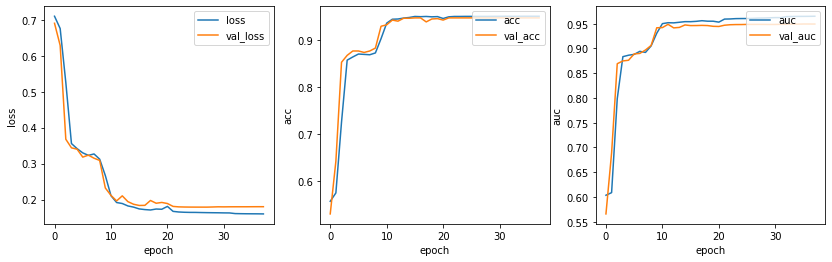

In [83]:
plot_history(history, ['loss', 'acc', 'auc'], figsize=(14,4));

In [84]:
pred_proba_test, pred_test = eval_metrics(relnn)

test set
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95      2592
         1.0       0.91      1.00      0.95      2592

    accuracy                           0.95      5184
   macro avg       0.95      0.95      0.95      5184
weighted avg       0.95      0.95      0.95      5184



In [85]:
log_to_wandb(y_test, pred_proba_test, pred_test)

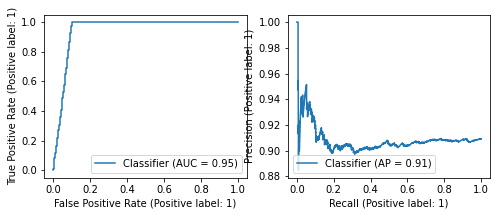

In [86]:
plot_roc_pr_curves(pred_proba_test, y_test[:,1]);

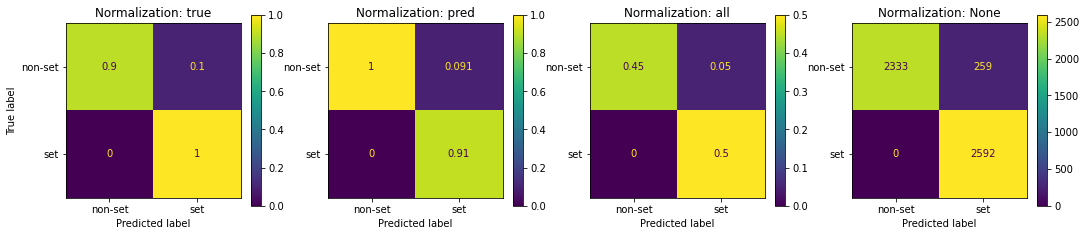

In [87]:
plot_confusion_matrices(y_test[:,1], pred_test);

In [88]:
wandb.finish()

acc,▁▁▄▆▆▇▇▇▇▇████████████████████████████
auc,▁▁▅▆▆▇▇▇▇▇████████████████████████████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▆▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
precision,▁▁▄▆▆▆▆▆▆▇████████████████████████████
recall,▁▂▅▇██████████████████████████████████
val_acc,▁▃▆▇▇▇▇▇▇█████████████████████████████
val_auc,▁▃▇▇▇▇▇▇▇█████████████████████████████
val_loss,█▇▄▃▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▃▆▆▆▆▆▆▆▇████████████████████████████


## Notes

**Observations:**
- (O1) RelNN sometimes gets stuck at high loss for a while and then finds a way to escape it during training. (Note: used Adam on RelNN's instead of SGD because of this!)

**To-Do's:**
- (TD1) come up with systematic experimental methodology to run broader set of experiments on in order to make fair comparisons.
- (TD2) CoRelNet (and other ESBN) use TCN. read paper. add to experiments and observe effects.
- (TD3) add spurious features. observe effect on each set of models.
- (TD4) implement grouping layer and test on appropriate task (e.g.: ABA task, etc.)
- (TD5) clean up some of the repetitive code

**Questions:**
- (Q1) why can CoRelNet predict?
    - with the encoding we're using, each pairwise relation is the number of attributes shared by the two entities. is this enough to predict 'setness'?
        - compute the set of relation matrices for all sets and non-sets and see if there is an example both sets and non-sets have the same relation matrix...
- (Q2) how do linear projection vs MLP encoders compare?
- (Q3) what effect exactly did the 'good initialization' of the linear projection spaces have on RelNN?
- (Q4) on O1: is there anything we can infer about the loss landscape for such models that might explain this?
